# CONSTANTS

In [241]:
EPOCHS = 171
LEARNING_RATE = 0.01
MANUAL_SEED = 1232
HIDDEN_NODE_COUNT = 64
DATASPLIT = 150
BATCH_SIZE = 64

OPTIMIZER="Adam"
ACTIVATION_FUNC = "ReLU"
WEIGHT_INIT = "Default"
LOSS_FUNC = "CEntropy"
POOLING_ALGO = "G. Add"
NEURON_COUNT = "7, 3*64, 2"
NUM_GCN_LAYERS = "3"

In [242]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/andreasholt/Library/Python/3.10/lib/python/site-packages/IPython/core/magics/pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['title', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy



# DATASET IMPORT

In [243]:
from visualize import GraphVisualization
from networkx.algorithms import community
import networkx as nx
import plotly
import os
import torch

import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader

%run visualize.py


dataset = TUDataset(root='dataset/Mutag', name='MUTAG')


<Figure size 640x480 with 0 Axes>

In [244]:
data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels,
}

print(data_details)



{'num_node_features': 7, 'num_edge_features': 4, 'num_classes': 2, 'num_node_labels': 7, 'num_edge_labels': 4}


# VISUALIZATION

In [245]:
def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(
        g,
        pos,
        node_text_position="top left",
        node_size=20,
    )
    fig = vis.create_figure()
    return fig


fig = create_graph(dataset[0])
fig.show()


In [246]:
# Defining the loaders
dataset = dataset.shuffle()


# Allocate N to train
train_dataset = dataset[:DATASPLIT]
# Allocate the remainder to test
test_dataset = dataset[DATASPLIT:]

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


# MODEL

In [247]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, in_features=7, hidden_channels=64, outfeatures = 2):
        super(GCN, self).__init__()

        # Input layer
        self.conv1 = GCNConv(in_features, hidden_channels)

        # Hidden layers
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)

        # Output layer
        self.lin = Linear(hidden_channels, outfeatures)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


# Set a manual seed andiinstantiate the model
torch.manual_seed(MANUAL_SEED)
model = GCN(hidden_channels=64)

# PLOTTING FUNCTIONS

In [248]:
import sklearn
from sklearn.metrics import RocCurveDisplay
import numpy as np

from sklearn import metrics

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)


# ROC AUC PLOT
def plotROCAUC(labels, probability_estimates, title, ax):
    # roc_auc = roc_auc_score(labels, predicted_labels)
    print(probability_estimates)

    fpr, tpr, _ = metrics.roc_curve(labels,  probability_estimates)
    auc = metrics.roc_auc_score(labels, probability_estimates)
    ax.set_title(title)
    ax.plot(fpr,tpr)
    ax.legend(["auc="+str(round(auc, 2))], handlelength=0, handletextpad=0)


    
    #RocCurveDisplay.from_predictions(labels, scores)


    #plt.show()

# ACCURACY PLOT
def plotAccuracy(losses, accuracies, title, ax):
    #fig, ax[0,1] = sub
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.plot(losses)
    ax.plot(accuracies)
    ax.plot(losses, label="Loss")
    ax.plot(accuracies, label="Accuracy")
    ax.legend(loc="lower center")
    
    
    #plt.show()

#def plotPRAUC(labels, scores, title):

def plotPRAUC(labels, probability_estimates, predicted_labels, title, ax):
    # roc_auc = roc_auc_score(labels, probability_estimates)
    precision, recall, _ = precision_recall_curve(labels, probability_estimates)
    pr_auc = auc(recall, precision)

    #plt.figure(figsize=(8, 6))
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    #ax.set_title('Precision-Recall Curve (PR AUC = {:.2f})'.format(pr_auc))
    ax.legend(["prauc="+str(round(pr_auc, 2))], handlelength=0, handletextpad=0)
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    #plt.grid(True)
    #plt.show()



# TRAINING AND TEST FUNCTIONS

In [249]:

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.CrossEntropyLoss()

train_probability_estimates, train_losses, train_accuracies = [], [], []
train_labels, train_predicted_labels = [], []


def train(t):
    model.train()

    for data in train_loader:  # Iterates the batches. We declared each batch to be of size 64

        # Calculate output, and get the maximum of those in order to obtain the predicted value
        out = model(data.x, data.edge_index, data.batch)
  
        cat = torch.argmax(out, dim=1)
        #print("Y: {}".format(data.y))
        #print("YHat: {}".format(cat))


        accuracy = (cat == data.y).float().mean()
        train_accuracies.append(accuracy.item())
        loss = loss_function(out, data.y)
        t.set_description("loss: %2f. accuracy %2f." % (loss, accuracy))
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append actual and preddicted to respective array. Have to be converted to NumPy arrays in order to flatten them.
        # We flatten them as 1D arrays are required by SK in order to calculate and plot ROC AUC
        arrayLabel = np.array(data.y)
        for value in arrayLabel.flatten():
            train_labels.append(value)
            

        arrayCat = np.array(cat)
        for value in arrayCat.flatten():
            train_predicted_labels.append(value)

        # Turn output tensor into numpy array
        arrayPred = out.detach().cpu().numpy()
        for index, value in enumerate(arrayPred):
            # We index into each array in arrayPred (2d array with 2 values)
            # Each value in array pred (ex.): [0.32, 0.95]. There are x of these, where x is batch size.
            # We index into each and obtain the predicted value depending on what the actual value (data.y) is for the corresponding index.
            train_probability_estimates.append(value[data.y[index]])

            #print("Label: {}. Two predicted values: {}. Chosen predicted value: {}".format(data.y[index], value, value[data.y[index]]))


test_losses, test_accuracies = [], []
test_labels, test_predicted_labels, test_probability_estimates = [], [], []



def test(loader):
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        #print("Out: {}".format(out))
        cat = torch.argmax(out, dim=1)


        accuracy = (cat == data.y).float().mean()
        test_accuracies.append(accuracy.item())

        loss = loss_function(out, data.y)
        test_losses.append(loss.item())

        arrayLabel = np.array(data.y)
        for value in arrayLabel.flatten():
            test_labels.append(value)

        arrayCat = np.array(cat)
        for value in arrayCat.flatten():
            test_predicted_labels.append(value)

        # Turn output tensor into numpy array
        arrayPred = out.detach().cpu().numpy()
        for index, value in enumerate(arrayPred):
            # We index into each array in arrayPred (2d array with 2 values)
            # Each value in array pred (ex.): [0.32, 0.95]. There are x of these, where x is batch size.
            # We index into each and obtain the predicted value depending on what the actual value (data.y) is for the corresponding index.
            test_probability_estimates.append(value[data.y[index]])




# EXECUTION

loss: 0.263726. accuracy 0.909091.: 100%|██████████| 170/170 [00:06<00:00, 25.90it/s]


[0.5648315, -0.034050666, -0.047393136, 0.46887332, -0.019788131, 0.13290031, 0.273529, 1.47097, 0.09085977, -0.8887286, 1.0194432, 0.07619282, 0.84759754, 1.5421233, -0.11639404, 0.12537207, 0.22658332, -0.24225974, 0.30639145, 0.30813867, 0.31259853, 0.21850787, 0.7684835, 0.7001987, 0.84980434, 0.17391562, 0.7230964, 0.7428627, -0.36912608, 0.7279823, -0.16517912, 0.4329955, -0.42844826, 0.62782335, 0.3013724, -0.269095, 0.18601608, 0.07355857, 0.46370733, 0.9566197, 0.09897736, 0.6032489, -0.085227124, -0.69911945, 0.7167171, 1.4567968, -0.048255138, 0.25368935, 0.9983815, -0.61892796, 0.9043061, 0.020680519, 1.6378998, -0.014520254, -0.35776573, -0.027516201, 0.52183145, 0.25902045, 0.70621, 0.21921785, 0.18418553, 0.6268141, 0.98484296, 0.10560462, 6.783634, -1.647017, 5.3522773, 5.614081, -5.2886863, -2.2315304, 6.5612445, 4.5935163, 4.416407, 1.9280906, 4.0363483, -5.743998, 8.87288, 4.765957, 3.907275, 7.4515104, -1.097041, -0.2774389, 6.929492, -2.1808796, -1.8807436, -1.7636

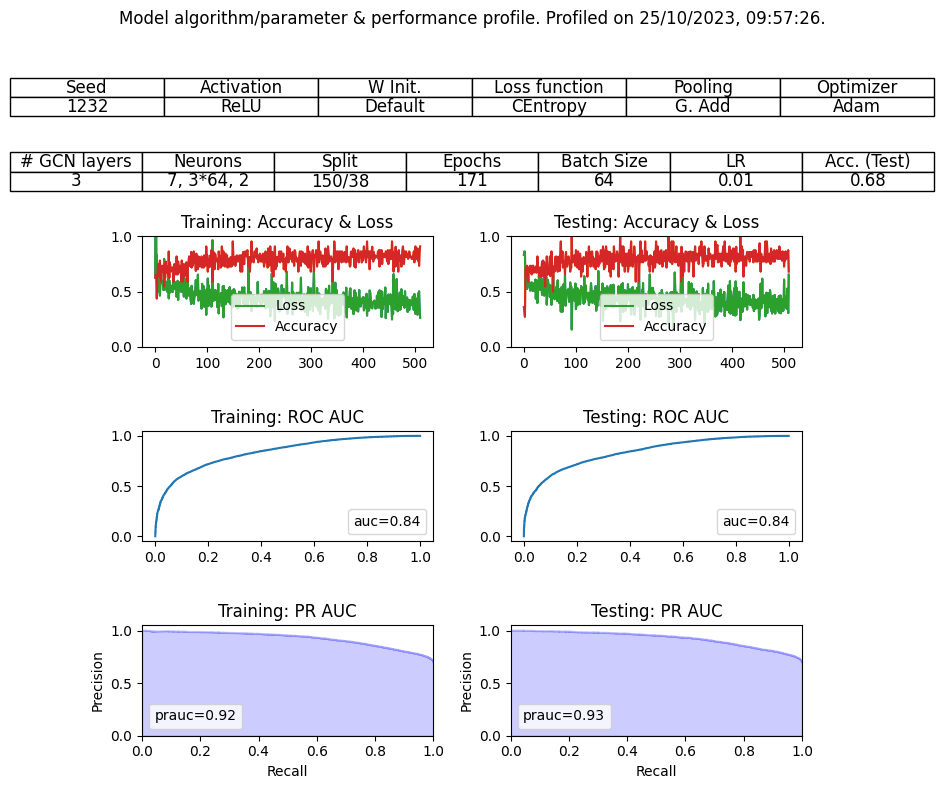

In [250]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, f1_score, precision_recall_curve
from tqdm import trange
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from datetime import datetime

for epoch in (t := trange(1, EPOCHS)):
    train(t)
    test(train_loader)
    

# Flags
plot_training = True
plot_testing = True

plot_accuracy = True
plot_rocauc = True
plot_prauc = True

fig = plt.figure(figsize=(10, 8))

gs = gridspec.GridSpec(4, 2)

ax1 = plt.subplot(gs[0, :])

table_data = [
    ["Seed", "Activation", "W Init.", "Loss function", "Pooling", "Optimizer", "# GCN layers", "Neurons", "Split", "Epochs", "Batch Size", "LR", "Acc. (Test)"],
        [str(MANUAL_SEED), ACTIVATION_FUNC, WEIGHT_INIT, LOSS_FUNC, POOLING_ALGO, OPTIMIZER, NUM_GCN_LAYERS, NEURON_COUNT, "{}/{}".format(DATASPLIT, 188-DATASPLIT), str(EPOCHS), BATCH_SIZE, str(LEARNING_RATE), str(round(test_accuracies[-1], 2))],
]

table_data_1 = [table_data[0][:len(table_data[0]) // 2], table_data[1][:len(table_data[1]) // 2]]
table_data_2 = [table_data[0][len(table_data[0]) // 2:], table_data[1][len(table_data[1]) // 2:]]

# Create the first table in the top subplot (upper section)
table_1 = ax1.table(cellText=table_data_1, cellLoc='center', loc='center')
table_1.auto_set_font_size(False)
table_1.set_fontsize(12)
table_1.scale(1.4, 1.4)

# Create the second table in the top subplot (lower section)
table_2 = ax1.table(cellText=table_data_2, cellLoc='center', loc='bottom')
table_2.auto_set_font_size(False)
table_2.set_fontsize(12)
table_2.scale(1.4, 1.4)



# Hide axis and display the table
#ax1 = plt.gca()
ax1.axis('off')

#divider_y = -1.1  # Adjust the y-coordinate as needed
#ax1.axhline(divider_y, color='black')


#precision, recall, thresholds = precision_recall_curve(train_labels, probs)


# Plot for train
if(plot_training):
    if(plot_accuracy):
        #ax00 = ax[0, 0]
        ax00 = plt.subplot(gs[1, 0])

        plotAccuracy(train_losses, train_accuracies, "Training: Accuracy & Loss", ax00)

    if(plot_rocauc):
        #ax10 = ax[0, 1]
        ax10 = plt.subplot(gs[2, 0])

        plotROCAUC(labels=train_labels,  probability_estimates=train_probability_estimates, title="Training: ROC AUC", ax=ax10)

    if(plot_prauc):
        #ax20, row 2, column 0
        ax20 = plt.subplot(gs[3, 0])
        plotPRAUC(labels=train_labels, probability_estimates=train_probability_estimates, predicted_labels=train_predicted_labels, ax=ax20, title="Training: PR AUC")
    


# Plot for test
if(plot_testing):
    if(plot_accuracy):
        #ax01 = ax[1, 0]
        ax01 = plt.subplot(gs[1, 1])
        plotAccuracy(test_losses, test_accuracies, "Testing: Accuracy & Loss", ax01)

    if(plot_rocauc):
        #ax11 = ax[1, 1]
        ax11 = plt.subplot(gs[2, 1])

        plotROCAUC(labels=test_labels, probability_estimates=test_probability_estimates, title="Testing: ROC AUC" ,ax=ax11)
    
    if(plot_prauc):
        #ax20, row 2, column 0
        ax21 = plt.subplot(gs[3, 1])
        plotPRAUC(labels=test_labels, probability_estimates=test_probability_estimates, predicted_labels=test_predicted_labels, ax=ax21, title="Testing: PR AUC")
    

now = datetime.now()

title = "Model algorithm/parameter & performance profile. Profiled on {}.".format(now.strftime("%d/%m/%Y, %H:%M:%S"))

fig.suptitle(title, fontsize=12, wrap=True)

plt.tight_layout()


print("Lengths:")
print(len(train_predicted_labels))
print(len(train_probability_estimates))


print("perf measure:")
print(perf_measure(test_labels, test_predicted_labels))






#plotPRAUC(test_labels, test_probability_estimates, test_predicted_labels, "PR AUC")

